In [ ]:
# pipeline

# carregar genoma

# criar reads

# criar os k mears

# fazer o grafo de DeBruijn

# otimizar

# reconstruir o genoma

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import product
import random

In [89]:
class Gerenciador_de_Genomas:
    def __init__(self):
        self.bases = ['A', 'C', 'G', 'T']
    def gerar_genoma(self,tamanho, random_state=None):
        random.seed(random_state)
        genoma = ''.join(random.choice(self.bases) for _ in range(tamanho))
        return genoma
    
    def gerar_reads(self,genoma, tamanho_read, cobertura=1.0,temperatura=0,random_state=None):
        reads_totais = [genoma[i:i+random.choice(range(tamanho_read-temperatura,tamanho_read+temperatura+1))]
                        for i in range(len(genoma)-tamanho_read+1)]
        numero_de_reads = int(len(reads_totais)*cobertura)
        random.seed(random_state)
        reads_cobertos = random.sample(reads_totais,numero_de_reads)
        return reads_cobertos
    
    def gerar_kmers(self, reads, k):
        kmers = set()
        for read in reads:
            for i in range(len(read) - k + 1):
                kmear = read[i:i + k]
                kmers.add(kmear)
        return list(kmers)
    
    def gerar_grafo_de_DeBruijn(self, kmers):
        Graph = nx.DiGraph()
        Graph.add_nodes_from(kmers)
        prefixos =  [kmer[:-1] for kmer in kmers]
        sufixos = [kmer[1:] for kmer in kmers]
        for i in range(len(kmers)):
            for j in range(len(kmers)):
                if prefixos[j] == sufixos[i]:
                    Graph.add_edge(kmers[i], kmers[j])
        return Graph

    def desenhar_grafo(self,grafo):
        pos = nx.spring_layout(grafo)
        plt.figure(figsize=(12, 8))
        
        nx.draw(grafo, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=5, font_color='black', font_weight='bold', arrows=True)
        plt.title("Grafo de De Bruijn")
        plt.show()

    def desenhar_grafo(self, grafo):
        pos = nx.spring_layout(grafo)
        plt.figure(figsize=(12, 8))
        labels_encurtados = {}
        for node in grafo.nodes():
            if len(node) > 8:
                novo_label = node[:3] + "..." + node[-3:]
            else:
                novo_label = node
            labels_encurtados[node] = novo_label
        # Desenhar grafo com os labels encurtados
        nx.draw(grafo, pos, labels=labels_encurtados,
                with_labels=True, node_size=1000,
                node_color='lightblue', font_size=8,
                font_color='black', font_weight='bold',
                arrows=True)

        plt.title("Grafo de De Bruijn")
        plt.show()

AAGCCCAATAAACCACTCTG


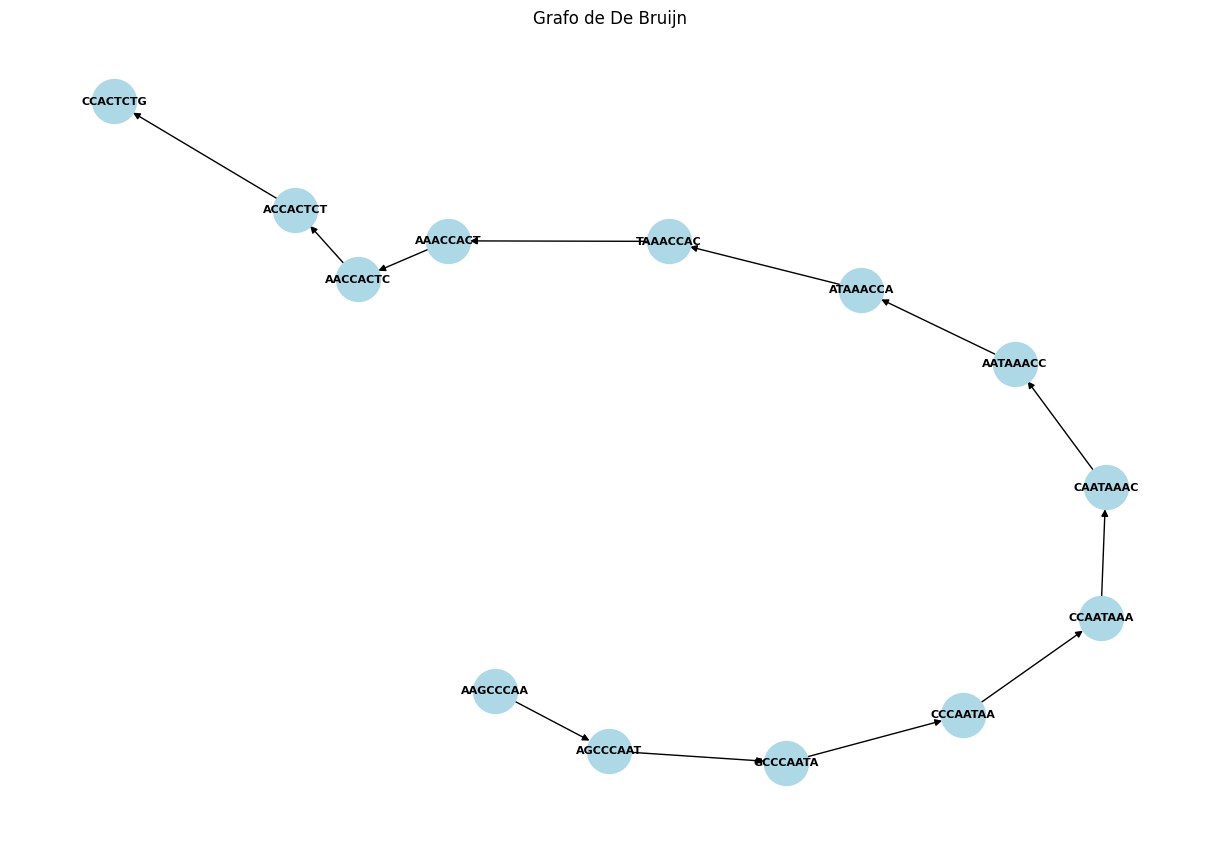

In [90]:
manager = Gerenciador_de_Genomas()
genoma_teste = manager.gerar_genoma(20, random_state=42)
print(genoma_teste)
reads_teste = manager.gerar_reads(genoma_teste, tamanho_read=20)
kmers_teste = manager.gerar_kmers(reads_teste, k=8)
grafo_de_bruijn_teste = manager.gerar_grafo_de_DeBruijn(kmers_teste)
manager.desenhar_grafo(grafo_de_bruijn_teste)

AAGCCCAATAAACCACTCTGACTGGCCGAATAGGGATATAGGCAACGACATGTGCGGCGACCCTTGCGACAGTGACGCTTTCGCCGTTGCCTAAACCTAT


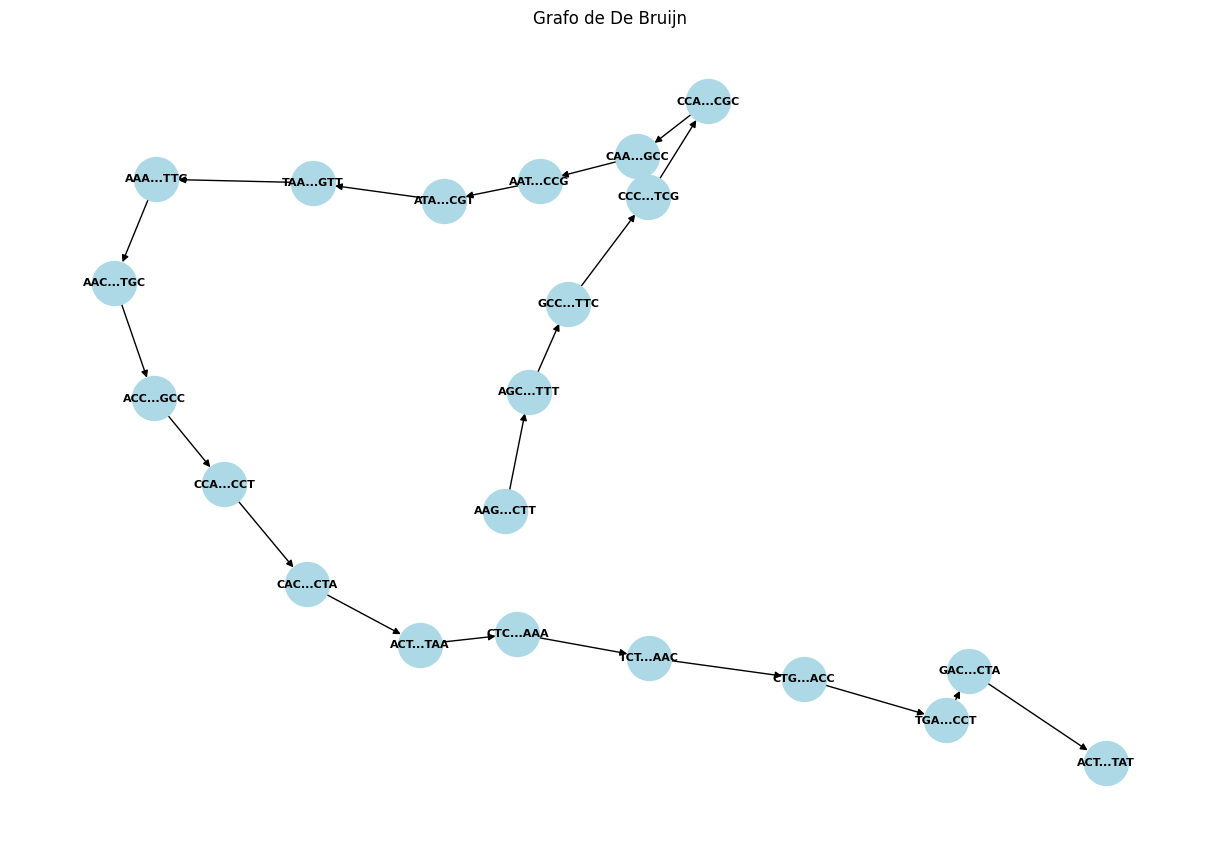

In [95]:
manager = Gerenciador_de_Genomas()
genoma_teste = manager.gerar_genoma(100, random_state=42)
print(genoma_teste)
reads_teste = manager.gerar_reads(genoma_teste, tamanho_read=100)
kmers_teste = manager.gerar_kmers(reads_teste, k=80)
grafo_de_bruijn_teste = manager.gerar_grafo_de_DeBruijn(kmers_teste)
manager.desenhar_grafo(grafo_de_bruijn_teste)

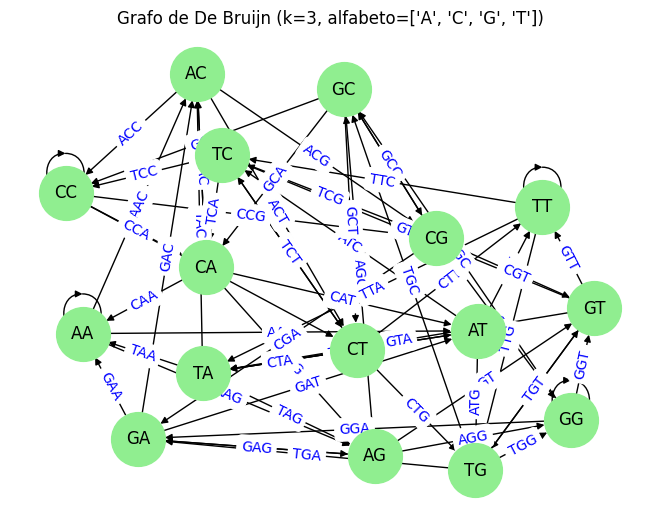

In [ ]:
# feito pelo gpt

def gerar_de_bruijn_grafo(k, alfabeto):
    G = nx.DiGraph()

    # Gerar todos os vértices possíveis com k-1 símbolos
    vertices = [''.join(p) for p in product(alfabeto, repeat=k-1)]
    G.add_nodes_from(vertices)

    # Gerar todas as arestas possíveis com k símbolos
    for p in product(alfabeto, repeat=k):
        prefixo = ''.join(p[:k-1])
        sufixo = ''.join(p[1:])
        G.add_edge(prefixo, sufixo, label=''.join(p))  # rótulo da aresta é o k-mer

    return G

# Parâmetros
k = 3
alfabeto = ['A', 'C', 'G', 'T']

# Criar o grafo
G = gerar_de_bruijn_grafo(k, alfabeto)

# Desenhar o grafo
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=1500, font_size=12, arrows=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue')

plt.title(f"Grafo de De Bruijn (k={k}, alfabeto={alfabeto})")
plt.show()